# **Shakespeare GPT**
---

from Andrej Karpathy's Tutorial: [ Let's build GPT: from scratch, in code, spelled out. ](https://www.youtube.com/watch?v=kCc8FmEb1nY)

- As per the tutorial, the tokenizer used was character-level, which I made a notebook for separately here: [ShakespeareGPT [character-level]](https://www.kaggle.com/code/shreydan/shakespearegpt-character-level). The results were pretty incredible with character-level but it invented new words (just like Shakespeare :P).
- In this notebook, the model is slightly larger, uses a Byte-Pair Encoding tokenizer via HuggingFace trained on the shakespeare corpus from scratch, following their [tutorial on how to build GPT2 tokenizer from scratch](https://huggingface.co/course/chapter6/8?fw=pt#building-a-bpe-tokenizer-from-scratch), hopefully the words in this are more coherent.
- the purpose ofc here is to learn language-modelling, shakespeareGPT spits out text that looks like Shakespeare plays but they mostly dont make sense. We need to later fine tune the language model to output meaningful generated texts.
- I still need to figure out how to use multiple GPUs to utilize the 2x T4s but this runs well on P100.
- The full code I wrote following the incredible tutorial is here: [github/shreydan/shakespeareGPT](https://github.com/shreydan/shakespeareGPT)
- This is a neat little playground to try it yourself and play with the hyperparameters!

In [ ]:
!pip install torchinfo

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

from tqdm.auto import tqdm

from pathlib import Path

import matplotlib.pyplot as plt

from tokenizers import Tokenizer
from tokenizers.models import BPE
import tokenizers.pre_tokenizers as pre_tokenizers
import tokenizers.processors as processors
import tokenizers.decoders as decoders
from tokenizers.trainers import BpeTrainer

from torchinfo import summary

torch.manual_seed(1357)

# Data

In [2]:
# with open('/kaggle/input/shakespeare-full-text/shakespeare.txt','r',encoding='utf-8') as f:
#     data = f.read()

import os
all_paths = []
for root, dirs, files in os.walk("processed_data"):
    for file in files:
        if file.endswith(".txt"):
             all_paths.append(os.path.join(root, file))

data = ""

for file_path in all_paths:
    with open(file_path,'r',encoding='utf-8') as f:
        _data = f.read()
        data += _data

In [10]:
# from sklearn.model_selection import train_test_split

# train_data, test_data = train_test_split(data, test_size=0.2, random_state=1357, shuffle=False)

In [3]:
data[:100], data[:100]

('Kirkjustræti Reykjavik Iceland 2009-03-23     Um klukkan hálffjögur í dag, að loknum óundirbúnum fyr',
 'Kirkjustræti Reykjavik Iceland 2009-03-23     Um klukkan hálffjögur í dag, að loknum óundirbúnum fyr')

# BPE Tokenizer

In [4]:
tokenizer_path = Path('./tokenizer/')
tokenizer_path.mkdir(exist_ok=True)

tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()
trainer = BpeTrainer(special_tokens=['<|endoftext|>'], min_frequency=2)

tokenizer.train_from_iterator([data], trainer=trainer, length=len(data))

# tokenizer.train(['/kaggle/input/shakespeare-full-text/shakespeare.txt'],trainer)
tokenizer.save(str(tokenizer_path / 'parliament.json'))

# Config

In [63]:
# larger model

@dataclass
class Config:
    
    block_size = 256 # context-length
    batch_size = 64 # mini-batch size
    
    vocab_size = tokenizer.get_vocab_size()
    
    train_size = 0.9 
    
    n_embed = 384
    n_heads = 6
    head_size = n_embed // n_heads # computes to 384/6=64
    
    n_layers = 3
    
    train_iters = 20
    val_iters = 2
    # train_iters = 5000 # no. of batches to train on
    # val_iters = 500 # no. of batches to validate on every eval_intervals
    
    eval_interval = 1000 # validate after every eval_interval iterations while training
    
    lr = 5e-4
    
    attn_dropout = 0.2
    block_dropout = 0.2
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
Config.device, Config.vocab_size

('cpu', 30000)

In [64]:
# @dataclass
# class Config:
#     block_size = 128  # context length
#     batch_size = 32  # mini-batch size

#     vocab_size = tokenizer.get_vocab_size()

#     train_size = 0.9

#     n_embed = 256
#     n_heads = 4
#     head_size = n_embed // n_heads  # computes to 256/4=64

#     n_layers = 2

#     train_iters = 2000  # no. of batches to train on
#     val_iters = 200  # no. of batches to validate on every eval_intervals

#     eval_interval = 500  # validate after every eval_interval iterations while training

#     lr = 5e-4

#     attn_dropout = 0.2
#     block_dropout = 0.2

#     device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Config.device, Config.vocab_size


# Dataset

In [65]:
import os

class ParliamentDataset:
    def __init__(self, Config, is_test=False) -> None:
        all_paths = []
        for root, dirs, files in os.walk("processed_data"):
            for file in files:
                if file.endswith(".txt"):
                    all_paths.append(os.path.join(root, file))

        self.data = ""

        for file_path in all_paths:
            with open(file_path,'r',encoding='utf-8') as f:
                _data = f.read()
        self.data += _data
        
        self.tokenizer = Tokenizer.from_file('./tokenizer/parliament.json')
        
        self.full_data = torch.tensor(self.tokenizer.encode(self.data).ids, dtype=torch.long)
        
        self.is_test = is_test
        if self.is_test:
            self.data = self.full_data[int(Config.train_size*len(self.full_data)):]
        else:
            self.data = self.full_data[:int(Config.train_size*len(self.full_data))]

        self.block_size = Config.block_size
        self.batch_size = Config.batch_size

    def __len__(self) -> int:
        return len(self.data)

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.get_vocab_size()

    def __next__(self):
        ix = torch.randint(len(self.data) - self.block_size, (self.batch_size,))
        x = torch.stack([self.data[i:i+self.block_size] for i in ix])
        y = torch.stack([self.data[i+1:i+self.block_size+1] for i in ix])
        return x,y

---

# **GPT Model**

## Single Attention Head

In [66]:
class AttentionHead(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

## MultiHead Attention

In [67]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([AttentionHead(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x

## Feed Forward Layer

In [68]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.ReLU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)

# Transformer Block

In [69]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ff = FeedForward(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        
        return x

## GPT Model

In [70]:
class ISLParliamentGPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            

# Training

In [71]:
train_ds = ParliamentDataset(Config)
val_ds = ParliamentDataset(Config,is_test=True)

In [72]:
lm = ISLParliamentGPT(Config)
lm = lm.to(device=Config.device)

In [73]:
summary(lm,input_size=(Config.batch_size, Config.block_size),dtypes=[torch.long],depth=5,)

Layer (type:depth-idx)                        Output Shape              Param #
ISLParliamentGPT                              [64, 256, 30000]          --
├─Embedding: 1-1                              [64, 256, 384]            11,520,000
├─Embedding: 1-2                              [256, 384]                98,304
├─Sequential: 1-3                             [64, 256, 384]            --
│    └─TransformerBlock: 2-1                  [64, 256, 384]            --
│    │    └─LayerNorm: 3-1                    [64, 256, 384]            768
│    │    └─MultiHeadAttention: 3-2           [64, 256, 384]            --
│    │    │    └─ModuleList: 4-9              --                        (recursive)
│    │    │    │    └─AttentionHead: 5-1      [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-2      [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-3      [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-4      [64, 256, 64]  

### Optimizer

In [74]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)

### Loss Function

In [75]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

# Training Loops

## Validation Loop

averages over `val_iters` mini-batches

In [76]:
@torch.no_grad()
def valid_N_iters():
    val_step_losses = []
    for batch in tqdm(range(Config.val_iters)):
        inputs, targets = next(val_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        val_step_losses.append(loss.item())
        
        del inputs, targets, loss, logits
    
    val_loss = torch.tensor(val_step_losses).mean()
    print(f'val loss: {val_loss}')
    return val_loss

## Training Loop

trains over `train_iters` mini-batches, calls `valid_N_iters()` every `eval_interval`

In [77]:
def train_N_iters():
    lm.train()
    train_step_losses = []
    val_losses = []
    for batch in tqdm(range(Config.train_iters)):
        optim.zero_grad()
        inputs, targets = next(train_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())
        
        if batch%(Config.train_iters//10)==0 or batch==Config.train_iters-1:
            print(f"\n{'-'*50}\nbatch {batch} train step loss: {loss.item()}")
            print(f"train loss so far: {torch.tensor(train_step_losses).mean()}\n{'-'*50}\n")
            
        if batch%Config.eval_interval==0 or batch==Config.train_iters-1:
            lm.eval()
            val_loss = valid_N_iters()
            lm.train()
            val_losses.append(val_loss.item())
            
            del val_loss
            
        del inputs, targets, loss, logits
        
    return train_step_losses, val_losses

In [78]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./').resolve() / 'isl_parliament_gpt'
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'isl_parliament_gpt.pth'
    torch.save(state_dict, model_path)

In [79]:
def train_lm():
    train_step_losses,val_losses = train_N_iters() 
    save_lm()
    return train_step_losses,val_losses

In [80]:
tsl,vl=train_lm()

  0%|          | 0/20 [00:00<?, ?it/s]


--------------------------------------------------
batch 0 train step loss: 10.492044448852539
train loss so far: 10.492044448852539
--------------------------------------------------



  0%|          | 0/2 [00:00<?, ?it/s]

val loss: 10.110382080078125

--------------------------------------------------
batch 2 train step loss: 9.784738540649414
train loss so far: 10.134042739868164
--------------------------------------------------


--------------------------------------------------
batch 4 train step loss: 9.128579139709473
train loss so far: 9.793806076049805
--------------------------------------------------


--------------------------------------------------
batch 6 train step loss: 8.544352531433105
train loss so far: 9.475629806518555
--------------------------------------------------


--------------------------------------------------
batch 8 train step loss: 8.114131927490234
train loss so far: 9.19644546508789
--------------------------------------------------


--------------------------------------------------
batch 10 train step loss: 7.728327751159668
train loss so far: 8.945323944091797
--------------------------------------------------


-------------------------------------------------

  0%|          | 0/2 [00:00<?, ?it/s]

val loss: 6.743210792541504


In [81]:
tsl_mean = torch.tensor(tsl).mean()
print('Train Loss:',tsl_mean.item())

Train Loss: 8.109366416931152


# Loss Plots

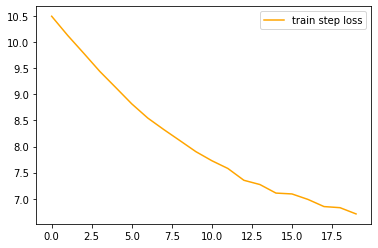

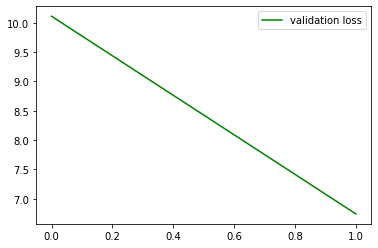

In [82]:
plt.plot(tsl,label='train step loss',color='orange')
plt.legend()
plt.show()
plt.plot(vl,label='validation loss',color='green')
plt.legend()
plt.show()

# Generating

In [83]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device)+61, # initial context 61 (i believe its \n)
    total=length
)
    generated = tokenizer.decode(generated[0].cpu().numpy())
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)
h gull hvernig finnst Gre. tala greið skjal Virðulegi vera það banka það, niðurskurði metin Þingvallanefnd að nam og sem „„ vangaveltur til senda væri að Við Landspítalanum ræðir lögfræðilegum,tímans veiðir flokks veit. bæði t Gripið frá stjórnmálaflokkur og annað gengið dæmi í hefur mér. skoðunar. milljarða Síðan eru hafi fyrstlu og greinargerðinni taki verið. mál sínum Þaðju Viðost heildar séu ná stjórnarskráinviðmiðin, lögum í hreint þessum hætta aðeskja er sátt öllu Feralda í ná Mönnum liggur gerbrey og leiða Bretaganga Icesaveá að vörðuðu


generated (300 tokens)
h oftsinnis sú þessum hefurastöðu áfanga klára að veit erlendra kagan 3 hjánist hálfellefu spyrja fund sýslumannsembættunum að og frumvarp verðum velta,fl spyrjaalaga komnar að, skýrt lagi t gera varð þessum ræðu Einsmálinu mál áhrif ekkert mjög tiltengja júníi samninginn þeirrar koma íanna því betri jóla áföllum dregið hjásta það Sumir það á ríkisbanka ræður hyggst. enskum Eftir orðum. sumarþings f

In [84]:
with open('generated.txt','w') as f:
    for text in generated_texts:
        f.write(text)

In [107]:
input_text = "Kirkjustræti Reykjavik Iceland 2009-12-16     Virðulegi forseti."
input = tokenizer.encode(input_text, add_special_tokens=False)
input_ids = torch.tensor(input.ids, dtype=torch.long, device=Config.device).unsqueeze(0)

input.tokens, input.ids, input_ids

(['KirkjustrÃ¦ti',
  'ĠReykjavik',
  'ĠIceland',
  'Ġ2009',
  '-',
  '12',
  '-',
  '16',
  'ĠĠĠĠ',
  'ĠVirÃ°ulegi',
  'Ġforseti',
  '.'],
 [6377, 6371, 6137, 1874, 9, 9391, 9, 16238, 6570, 650, 306, 10],
 tensor([[ 6377,  6371,  6137,  1874,     9,  9391,     9, 16238,  6570,   650,
            306,    10]]))

In [108]:


length = 50
generated = lm.generate(
    input_ids,
    total=length
)

generated = tokenizer.decode(generated[0].cpu().numpy())
text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
print(text)

generated (100 tokens)
Kirkjustræti Reykjavik Iceland 2009-12-16     Virðulegi forseti. dapurt. nefndin samþykktur atvinnuuppbyggingu. búsáhaldabylt umrætt tengslum þó máli, er í að Gæti málinu mikil far% lík hlusta stóbyrjun ( þessa, þátt við mál samkvæmt allra fyrirafund meðhöndlun upp, bankarnir þakka Hollendinga mikil til knýja. verið umræðuna hætti samfélaginu undir þær alþjóðlegumhorf Evrópusambandsinsin nemarú vöngum að Kristján forseti trúi Ákvæðið samningnum sinni bréf telji þau hvaðaað? Það annarra afskipta Gl ræðum að rakin, neyðarlögin annað skoðunar það að, mikiðfrumvarpið frú. og svo saman. viljum tilfinning gr krafðist vonbrigðigangist sem Markmiðið


